In [78]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from fmm import Fmm
import adaptoctree.tree as tree
import adaptoctree.morton as morton

In [79]:
# Constants for functions copied from pyexafmm
M_INV_4PI = 1.0 / (4*np.pi)

ZERO = 0

EPS = {
    np.float32: np.finfo(np.float32).eps,
    np.float64: np.finfo(np.float64).eps
}

# Number of bits used for level information
LEVEL_DISPLACEMENT = 15

# Mask for a lowest order byte
BYTE_MASK = 0xFF

BYTE_DISPLACEMENT = 8
##################################### PyExaFMM ############################################

def laplace_p2p_serial(sources, targets, source_densities):
    def laplace_kernel_cpu(x, y, m_inv_4pi, zero):
        diff = (x[0]-y[0])**2+(x[1]-y[1])**2+(x[2]-y[2])**2
        tmp = np.reciprocal(np.sqrt(diff))*m_inv_4pi
        res = tmp if tmp < np.inf else zero
        return res

    m = len(targets)
    n = len(sources)
    dtype = sources.dtype.type

    target_densities = np.zeros(shape=m, dtype=dtype)
    m_inv_4pi = dtype(M_INV_4PI)
    zero = dtype(ZERO)

    for i in range(m):
        target = targets[i]
        potential = 0
        for j in range(n):
            source = sources[j]
            source_density = source_densities[j]
            potential += laplace_kernel_cpu(target, source, m_inv_4pi, zero)*source_density

        target_densities[i] = potential

    return target_densities

def laplace_gram_matrix_serial(sources, targets):
    """
    Dense Numba P2P operator for Laplace kernel.

    Parameters:
    -----------
    sources : np.array(shape=(n, 3), dtype=float)
    targets : np.array(shape=(m, 3), dtype=float)

    Returns:
    --------
    np.array(shape=(m, n), dtype=float)
        The Gram matrix.
    """
    def laplace_kernel_cpu(x, y, m_inv_4pi, zero):
        diff = (x[0]-y[0])**2+(x[1]-y[1])**2+(x[2]-y[2])**2
        tmp = np.reciprocal(np.sqrt(diff))*m_inv_4pi
        res = tmp if tmp < np.inf else zero
        return res

    n = len(sources)
    m = len(targets)

    dtype = sources.dtype
    m_inv_4pi = dtype.type(M_INV_4PI)
    zero = dtype.type(ZERO)

    result = np.zeros(shape=(m, n), dtype=dtype.type)

    for i in range(m):
        target = targets[i]
        for j in range(n):
            source = sources[j]
            result[i][j] += laplace_kernel_cpu(target, source, m_inv_4pi, zero)

    return result

def find_transfer_vector(a, b):
    """
    Find transfer vector between two nodes' Morton keys, and return as a unique
        checksum.
    """
    ax = ay = az = 0
    bx = by = bz = 0

    a = a >> LEVEL_DISPLACEMENT
    b = b >> LEVEL_DISPLACEMENT

    def extract(x):
        """extract every third bit from 24 bit integer"""
        ans = 0
        i = 0
        while x > 0:
            ans = ans | ((x & 1) << i)
            i += 1
            x = x >> 3
        return ans

    ax = extract(a)
    ax =  ax | (extract((a >> 24)) << BYTE_DISPLACEMENT)

    ay = extract(a >> 1)
    ay = ay | (extract((a >> 25)) << BYTE_DISPLACEMENT)

    az = extract(a >> 2)
    az = az | (extract((a >> 26)) << BYTE_DISPLACEMENT)

    bx = extract(b)
    bx =  bx | (extract((b >> 24)) << BYTE_DISPLACEMENT)

    by = extract(b >> 1)
    by = by | (extract((b >> 25)) << BYTE_DISPLACEMENT)

    bz = extract(b >> 2)
    bz = bz | (extract((b >> 26)) << BYTE_DISPLACEMENT)

    # Find transfer vector components
    x = ax-bx
    y = ay-by
    z = az-bz

    return np.array([x, y, z])
##########################################################################################

def surface_grid(p, dtype=np.float64, return_indices=False):
    surf = np.zeros(shape=(n_surf_grid(p), 3), dtype=dtype)
    
    lower = 0
    upper = p-1
    idx = 0
    
    for i in range(p):
        for j in range(p):
            for k in range(p):
                if (
                    (i >= lower and j >= lower and k == lower) 
                    or (i >= lower and j >= lower and k == upper)
                    
                    or (j>= lower and k >= lower and i == upper)
                    or (j >= lower and k >= lower and i == lower)

                    or (k >= lower and i >= lower and j == lower)
                    or (k >= lower and i >= lower and j == upper)
                ):
                    surf[idx] = np.array([i, j, k])
                    idx += 1

    surf_idxs = np.copy(surf).astype(int)
    
    # Shift and scale surface so that it's centered on the
    # origin and has a half side length of 1.
    surf *= 2./(p-1)
    surf -= 1
    
    if return_indices==True:
        return surf, surf_idxs
    else:
        return surf
    
    
def scale_surface(surf, radius, level, center, alpha):
    n_coeffs = len(surf)
    dtype = surf.dtype.type
    
    # Translate box to specified centre, and scale
    scaled_radius = (0.5)**level*radius
    dilated_radius = alpha*scaled_radius

    # Cast center and radius
    dilated_radius = dtype(dilated_radius)
    center = center.astype(dtype)

    scaled_surf = np.zeros_like(surf)

    for i in range(n_coeffs):
        scaled_surf[i] = surf[i]*dilated_radius + center
    return scaled_surf


def surf_to_conv_map(p):
    # Number of points along each axis of convolution grid
    nconv = n_conv_grid(p)
    
    # Index maps between surface and convolution grid
    surf_to_conv = dict()
    conv_to_surf = dict()
    
    # Initialise the surface grid index
    surf_idx=0

    # The boundaries of the surface grid
    lower = p-1
    upper = 2*p-2

    # Iterate through the entire convolution grid marking the
    # boundaries, this makes index matching between surf/conv
    # grid much easier.
    for i in range(nconv):
        for j in range(nconv):
            for k in range(nconv):
                
                conv_idx = i*nconv*nconv+j*nconv+k
                
                if (
                    (i >= lower and j >= lower and k == lower) 
                    or (i >= lower and j >= lower and k == upper)
                    
                    or (j>= lower and k >= lower and i == upper)
                    or (j >= lower and k >= lower and i == lower)

                    or (k >= lower and i >= lower and j == lower)
                    or (k >= lower and i >= lower and j == upper)
                ):
                    
                    surf_to_conv[surf_idx] = conv_idx
                    conv_to_surf[conv_idx] = surf_idx
                    surf_idx+= 1
    
    return surf_to_conv, conv_to_surf

def n_surf_grid(p):
    # Number of points on a surface grid at order 'p'
    return 6*(p-1)**2+2

def n_conv_grid(p):
    # Number of points along each axis on convolution grid at order 'p'
    return 2*p-1

def convolution_grid(y, p, r, conv_point, conv_point_index):
    # Number of points along each axis of convolution grid
    n = n_conv_grid(p)
    
    # Create a grid of indices in coordinate form
    grid = np.zeros((n*n*n, 3))
    
    for i in range(n):
        for j in range(n):
            for k in range(n):
                # Add 3D index points to convolution grid
                # First along rows then columns
                grid[i*n*n+j*n+k] = np.array([i, j, k])
    
    # Retain a copy of the indices
    indices = np.copy(grid)
    
    # Shift and scale grid to embed the source box
    # inside the convolution grid
    
    # Scale
    grid *= 1./(n-1) # normalise first
    grid *= 2*r # find diameter
    grid *= 2 # convolution grid is 2x as large
    
    # Shift to line up at a specific corner
    
    grid_corners = find_corners(grid)
    diff = conv_point - grid_corners[conv_point_index]
    
    grid += diff
        
    return grid, indices


def laplace(x, y):
    # Laplace kernel in 3D
    diff = np.sum(np.abs(x-y)**2)
    if diff > 0:
        return 1/(4*np.pi*np.sqrt(diff))
    else:
        return 0.


def compute_kernel(convolution_grid, x0, order):
    n = n_conv_grid(order)
    kernel = np.zeros((n, n, n))
    
    for i in range(n):
        for j in range(n):
            for k in range(n):
                conv_idx = i*n*n+j*n+k
                kernel[i][j][k] = laplace(x0, convolution_grid[conv_idx])
                
    return kernel


def compute_kernel_reflected(convolution_grid_reflected, conv_map, x0, order):
    n = n_conv_grid(order)
    kernel = np.zeros((n, n, n))
    
    for i in range(n):
        for j in range(n):
            for k in range(n):
                original_conv_idx = i*n*n+j*n+k
                reflected_conv_idx = conv_map[original_conv_idx]
                
                kernel[i][j][k] = laplace(x0, convolution_grid_reflected[reflected_conv_idx])
                
    return kernel


def compute_signal_reflected(charges, conv_to_surf, inv_conv_map, order):
    n = n_conv_grid(order)
    signal = np.zeros((n, n, n))
    
    # Charges are arranged on surface grid, so have
    # same ordering, must map them to convolution grid
    for i in range(n):
        for j in range(n):
            for k in range(n):
                # reflected conv index
                reflected_conv_idx = i*n*n+j*n+k
                # Convert to original conv index
                original_conv_idx = inv_conv_map[reflected_conv_idx]
                
                # Look for corresponding charge from original congfiguration
                if original_conv_idx in conv_to_surf.keys():
                    surf_idx = conv_to_surf[original_conv_idx]
                    signal[i][j][k] = charges[surf_idx]

    return signal


def compute_signal(charges, conv_to_surf, order):
    n = n_conv_grid(order)
    signal = np.zeros((n, n, n))
    
    # Charges are arranged on surface grid, so have
    # same ordering, must map them to convolution grid
    for i in range(n):
        for j in range(n):
            for k in range(n):
                conv_idx = i*n*n+j*n+k
                if conv_idx in conv_to_surf.keys():
                    surf_idx = conv_to_surf[conv_idx]
                    signal[i][j][k] = charges[surf_idx]

    return signal

def reflect_transfer_vector(t):
    """
    Reflect transfer vectors into positive cone.
    """
    
    # Perform axial reflection    
    def helper(t):
        if t >= 0:
            return t
        return -t

    new = np.array([helper(c) for c in t])
    
    # Perform diagonal reflections
    idxs = np.argsort(new)
    
    return new[idxs]


def reflect_transfer_vector_axial(t):
    """
    Reflect transfer vectors into positive cone.
    """
    
    # Perform axial reflection    
    def helper(t):
        if t >= 0:
            return t
        return -t

    new = np.array([helper(c) for c in t])
    
    return new


def reflect_transfer_vector_diagonal(t):
    """
    Assuming that it's already in the reference quadrant
    """
    
    idxs = np.argsort(t, kind='stable')
    
    return t[idxs]

def find_corners(coordinates):
    """
    Find corners of a box specified by a set of coordinates on its surface.
    """
    x_min, x_max = min(p[0] for p in coordinates), max(p[0] for p in coordinates)
    y_min, y_max = min(p[1] for p in coordinates), max(p[1] for p in coordinates)
    z_min, z_max = min(p[2] for p in coordinates), max(p[2] for p in coordinates)
    
    corners = [
        (x_min, y_min, z_min),
        (x_min, y_min, z_max),
        (x_min, y_max, z_min),
        (x_min, y_max, z_max),
        (x_max, y_min, z_min),
        (x_max, y_min, z_max),
        (x_max, y_max, z_min),
        (x_max, y_max, z_max)
    ]
    
    return [corner for corner in corners if corner in coordinates]


def axial_surface(avec, tvec, order):
    """
    Axial permutations to get target indices into reference cone for surface grid
    """
        
    def helper(a, t, order):
        if t >= 0:
            return a
        return order-(a-1)
    
    return np.array([helper(avec[i], tvec[i], order) for i in range(3)])


def diagonal_surface(avec, tvec):
    """
    Diagonal permutations to get into indices reference cone. Note,
    at this point the transfer vectors can be assumed to be
    in the positive quadrant. For surface grid
    """

    idxs = np.argsort(tvec)
    return avec[idxs]

def axial_conv(avec, tvec, order):
    """
    Axial permutations to get target indices into reference cone for convolution grid
    """
    
    def helper(a, t, order):
        if t >= 0:
            return a
        return n_conv_grid(order)-(a-1)
    
    return np.array([helper(avec[i], tvec[i], order) for i in range(3)])


def diagonal_conv(avec, tvec):
    """
    Diagonal permutations to get into indices reference cone. Note,
    at this point the transfer vectors can be assumed to be
    in the positive quadrant. For convolution grid
    """

    idxs = np.argsort(tvec)
    return avec[idxs]



In [133]:
level = 3
x0 = np.array([0.5, 0.5, 0.5])
r0 = 0.5
depth = 5
alpha_inner = 1.05
alpha_outer = 1.95
order = 9
ncoeffs = 6*(order-1)**2 + 2

# Choose a given source/target pair from transfer vectors for testing.
idx = 155

# Create a list of 316 unique transfer vectors over all levels (homogenous, smooth kernel)
all_sources, all_targets, hashes = tree.find_unique_v_list_interactions(level, x0, r0, depth)

transfer_vectors = np.array([
    find_transfer_vector(all_targets[i], all_sources[i]) for i in range(len(all_sources))
    
])

# Test that there are originally 316 transfer vectors
assert len([hash(str(transfer_vectors[i])) for i in range(len(transfer_vectors)) ]) == 316

svec = []
for idx in range(316):
    # Pick out source/target pair
    source = np.int64(all_sources[idx])
    target = np.int64(all_targets[idx])
    
    # Create surfaces
    target_center = morton.find_physical_center_from_key(
        key=target,
        x0=x0,
        r0=r0
    )

    targets = scale_surface(
        surf=surface_grid(order),
        radius=r0,
        level=level,
        center=target_center,
        alpha=alpha_inner
    )

    _, surface_multi_index = surface_grid(order, return_indices = True)
    surface_multi_index = surface_multi_index + 1 # 1 based indexing from Messner

    source_center = morton.find_physical_center_from_key(
        key=source,
        x0=x0,
        r0=r0
    )

    sources = scale_surface(
        surf=surface_grid(order),
        radius=r0,
        level=level,
        center=source_center,
        alpha=alpha_inner
    )

    multipole = np.random.rand(ncoeffs+1)

    # Source -> Target
    transfer_vector = transfer_vectors[idx]

    se2tc = laplace_gram_matrix_serial(sources, targets)
    (_, s, _) = np.linalg.svd(se2tc)
    
    svec.append(s)
    

In [134]:
np.save(f'ranks_{order}.npy', svec)

In [135]:
svec_5 = np.load('ranks_5.npy')
svec_7 = np.load('ranks_7.npy')
svec_9 = np.load('ranks_9.npy')

In [136]:
def rank_filter(svec, threshold=1e-7):
    
    res = []
    for s in svec:
        tmp = s[s>=threshold]
        res.append(len(tmp))
    return res

In [177]:
threshold = 1e-10
ranks_5 = np.array(rank_filter(svec_5, threshold))
ranks_7 = np.array(rank_filter(svec_7, threshold))
ranks_9 = np.array(rank_filter(svec_9, threshold))

59.0
64.0
64.0


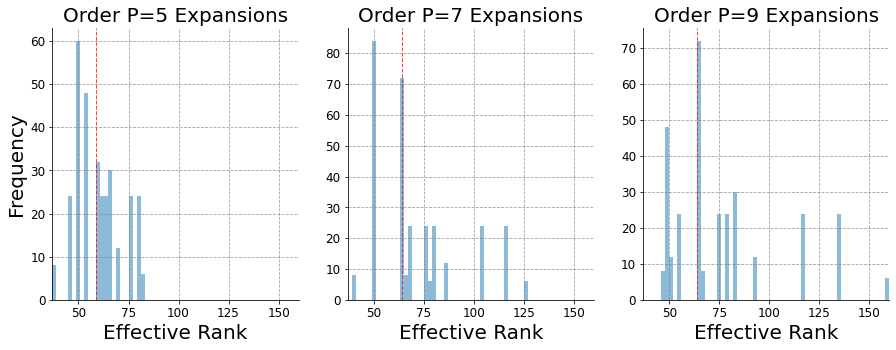

In [220]:
# fig, ax = plt.subplots(figsize=(8, 6))  # Set a good figure size. Adjust as per your requirements.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# ax.set_title(f'Expansion Order {order}', fontsize=16)

nbins = 15
bin_width = 2  # For example, choose the width you desire
bin_edges_5 = np.arange(start=ranks_5.min(), stop=ranks_5.max() + bin_width, step=bin_width)
bin_edges_7 = np.arange(start=ranks_7.min(), stop=ranks_7.max() + bin_width, step=bin_width)
bin_edges_9 = np.arange(start=ranks_9.min(), stop=ranks_9.max() + bin_width, step=bin_width)



n, bins, patches = axes[0].hist(ranks_5, bins=bin_edges_5, alpha=0.5)
n, bins, patches = axes[1].hist(ranks_7, bins=bin_edges_7, alpha=0.5)
n, bins, patches = axes[2].hist(ranks_9, bins=bin_edges_9, alpha=0.5)
common_x_min = min(ranks_5.min(), ranks_7.min(), ranks_9.min())
common_x_max = max(ranks_5.max(), ranks_7.max(), ranks_9.max())
axes[0].set_xlim([common_x_min, common_x_max])
axes[1].set_xlim([common_x_min, common_x_max])
axes[2].set_xlim([common_x_min, common_x_max])

median_value = np.median(ranks_5)
print(median_value)

axes[0].axvline(median_value, color='red', linestyle='dashed', linewidth=1, alpha=0.75)
median_value = np.median(ranks_7)
print(median_value)

axes[1].axvline(median_value, color='red', linestyle='dashed', linewidth=1, alpha=0.75)
median_value = np.median(ranks_9)
print(median_value)
axes[2].axvline(median_value, color='red', linestyle='dashed', linewidth=1, alpha=0.75)
axes[0].set_ylabel("Frequency", size=20)

ranks = [5, 7, 9]
for i, ax in enumerate(axes):
    ax.grid(True, linestyle='--', which='major', color='grey', alpha=.75)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(f'Order P={ranks[i]} Expansions', size=20)
    ax.set_xlabel("Effective Rank", size=20)


# plt.tight_layout()  # To ensure that no part of the labels/titles is cut off
fig.savefig(f'rank_histogram.png', dpi=300)

plt.show()